In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = "../model/keypoint_classifier/new_keypoint.csv"
model_save_path = '../model/keypoint_classifier/no_pointer.hdf5'
tflite_save_path = '../model/keypoint_classifier/no_pointer.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 7

# Dataset reading & Filtering

In [4]:
import numpy as np
import pandas as pd


# Read the dataset from the CSV file
df = pd.read_csv(dataset)

# Filter rows with label 7
data = df[df[df.columns[0]] != 7]

# Data Balancing

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Specify the target variable
balance_by = data.columns[0]

# Function to determine the sampling strategy
def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

# Calculate the median count for balancing
n_samples = int(data[balance_by].value_counts().median())

# Balancing the data using RandomUnderSampler and RandomOverSampler
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy(data.drop(balance_by, axis=1), data[balance_by], n_samples, t='majority'))
X_under, y_under = under_sampler.fit_resample(data.drop(balance_by, axis=1), data[balance_by])

over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'))
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

balanced_data = pd.DataFrame(X_bal)
balanced_data[balance_by] = y_bal

# Print class distribution before resampling
unique_classes_before, class_counts_before = np.unique(data[balance_by], return_counts=True)
print("Class distribution before resampling:")
for class_label, count in zip(unique_classes_before, class_counts_before):
    print(f"Class {class_label}: {count} instances")

# Print class distribution after resampling
unique_classes_after, class_counts_after = np.unique(balanced_data[balance_by], return_counts=True)
print("\nClass distribution after resampling:")
for class_label, count in zip(unique_classes_after, class_counts_after):
    print(f"Class {class_label}: {count} instances")


Class distribution before resampling:
Class 0: 4223 instances
Class 1: 3929 instances
Class 2: 3871 instances
Class 3: 3283 instances
Class 4: 3242 instances
Class 5: 3256 instances
Class 6: 3223 instances

Class distribution after resampling:
Class 0: 3283 instances
Class 1: 3283 instances
Class 2: 3283 instances
Class 3: 3283 instances
Class 4: 3283 instances
Class 5: 3283 instances
Class 6: 3283 instances


In [6]:
balanced_data.head()

,0.0,0.0.1,0.23605150214592274,-0.3776824034334764,0.30472103004291845,-0.630901287553648,0.3605150214592275,-0.8412017167381974,0.2832618025751073,-0.9957081545064378,...,-0.5150214592274678,-0.2017167381974249,-0.5793991416309013,0.11158798283261803,-0.6738197424892703.1,0.15450643776824036,-0.51931330472103,0.04721030042918455,-0.4592274678111588,0
0,0.0,0.0,-0.158470,-0.153005,-0.226776,-0.355191,-0.215847,-0.538251,-0.204918,-0.683060,...,-0.956284,0.207650,-0.442623,0.213115,-0.603825,0.207650,-0.702186,0.185792,-0.797814,0
1,0.0,0.0,0.235632,-0.120690,0.545977,-0.402299,0.620690,-0.741379,0.505747,-0.988506,...,-0.597701,-0.045977,-0.758621,0.028736,-0.804598,0.034483,-0.591954,0.022989,-0.591954,0
2,0.0,0.0,0.213333,-0.080000,0.391111,-0.226667,0.528889,-0.351111,0.648889,-0.435556,...,-0.933333,-0.204444,-0.328889,-0.293333,-0.466667,-0.351111,-0.564444,-0.391111,-0.653333,0
3,0.0,0.0,0.195556,-0.137778,0.324444,-0.320000,0.422222,-0.448889,0.524444,-0.520000,...,-0.951111,-0.075556,-0.520000,-0.124444,-0.644444,-0.146667,-0.720000,-0.155556,-0.791111,0
4,0.0,0.0,-0.119760,-0.257485,-0.137725,-0.461078,-0.113772,-0.634731,-0.089820,-0.760479,...,-0.970060,0.233533,-0.461078,0.263473,-0.640719,0.281437,-0.754491,0.287425,-0.856287,0


In [7]:
X_dataset = np.array(balanced_data.drop(balance_by, axis=1))
X_dataset

array([[ 0.        ,  0.        , -0.15846995, ..., -0.70218579,
         0.18579235, -0.79781421],
       [ 0.        ,  0.        ,  0.23563218, ..., -0.59195402,
         0.02298851, -0.59195402],
       [ 0.        ,  0.        ,  0.21333333, ..., -0.56444444,
        -0.39111111, -0.65333333],
       ...,
       [ 0.        ,  0.        ,  0.3828125 , ..., -0.71875   ,
        -0.265625  , -0.609375  ],
       [ 0.        ,  0.        ,  0.30503979, ..., -0.47480106,
         0.0795756 , -0.3872679 ],
       [ 0.        ,  0.        ,  0.22807018, ..., -0.47953216,
        -0.43859649, -0.48538012]])

In [8]:
y_dataset = np.array(balanced_data[balance_by])
y_dataset

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1147 (4.48 KB)
Trainable params: 1147 (4.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [28]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
111/135 [=======================>......] - ETA: 0s - loss: 0.5838 - accuracy: 0.8116
Epoch 1: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 1s 3ms/step - loss: 0.5801 - accuracy: 0.8117 - val_loss: 0.3696 - val_accuracy: 0.9032
Epoch 2/1000
 78/135 [================>.............] - ETA: 0s - loss: 0.5796 - accuracy: 0.8141

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/135 [===========================>..] - ETA: 0s - loss: 0.5758 - accuracy: 0.8145
Epoch 2: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.5756 - accuracy: 0.8143 - val_loss: 0.3575 - val_accuracy: 0.9132
Epoch 3/1000
135/135 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.8143
Epoch 3: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.5796 - accuracy: 0.8143 - val_loss: 0.3588 - val_accuracy: 0.9125
Epoch 4/1000
113/135 [========================>.....] - ETA: 0s - loss: 0.5853 - accuracy: 0.8131
Epoch 4: saving model to ../model/keypoint_classifier\no_pointer.hdf5
135/135 [==============================] - 0s 3ms/step - loss: 0.5848 - accuracy: 0.8133 - val_loss: 0.3609 - val_accuracy: 0.9121
Epoch 5/1000
108/135 [=======================>......] - ETA: 0s - loss: 0.5876 - accuracy: 0.8095
Epoch 5: saving mo

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

45/45 [==============================] - 0s 1ms/step - loss: 0.3704 - accuracy: 0.9067


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 99ms/step
[1.1432024e-03 1.1343946e-05 2.2252920e-07 1.7230863e-02 9.8059571e-01
 5.4333027e-04 4.7526552e-04]
4


# Confusion matrix

In [18]:
series = pd.Series(y_test)

# Use the value_counts method
value_counts_result = series.value_counts()

print(value_counts_result)


1    864
5    834
4    820
3    818
2    810
6    804
0    796
Name: count, dtype: int64


180/180 [==============================] - 0s 1ms/step
[0, 1, 2, 3, 4, 5, 6]


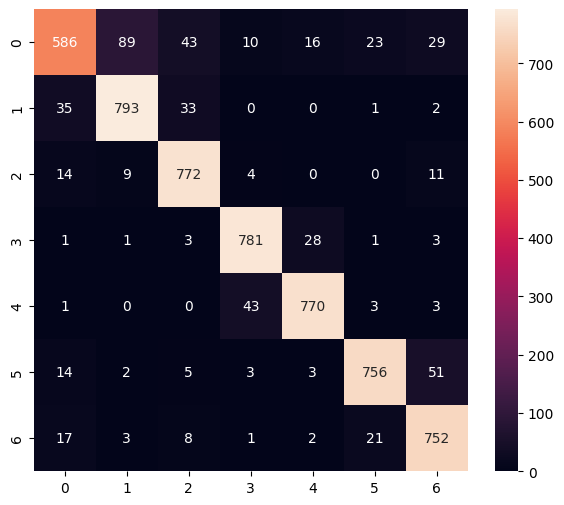

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       796
           1       0.88      0.92      0.90       864
           2       0.89      0.95      0.92       810
           3       0.93      0.95      0.94       818
           4       0.94      0.94      0.94       820
           5       0.94      0.91      0.92       834
           6       0.88      0.94      0.91       804

    accuracy                           0.91      5746
   macro avg       0.91      0.91      0.91      5746
weighted avg       0.91      0.91      0.91      5746



In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    print(labels)
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [20]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmpn8n3l3e0\assets


INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmpn8n3l3e0\assets


6676

# Inference test

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [23]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
input_data = np.array([X_test[0]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [25]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.1432033e-03 1.1343967e-05 2.2252959e-07 1.7230880e-02 9.8059571e-01
 5.4333051e-04 4.7526552e-04]
4


In [27]:
y_test[0]

4